## Advanced Retrieval Augmented Generation (RAG)
In this notebook I will be taking a look at the advanced ReACT agents from HuggingFace and how they could be used to build advanced Pipelines with LLM's. Large Language Models (LLMs) struggle with specific tasks like logic, calculation, and search. To address this, an agent framework can be used, where the agent, driven by an LLM, utilizes specialized tools to perform these tasks. This approach has shown excellent results, achieving state-of-the-art performance on benchmarks like HumanEval. What differentiates the HuggingFace Agents from other agents available is the ability to store memory and to reason and verify if the problem at hand is solved or not.

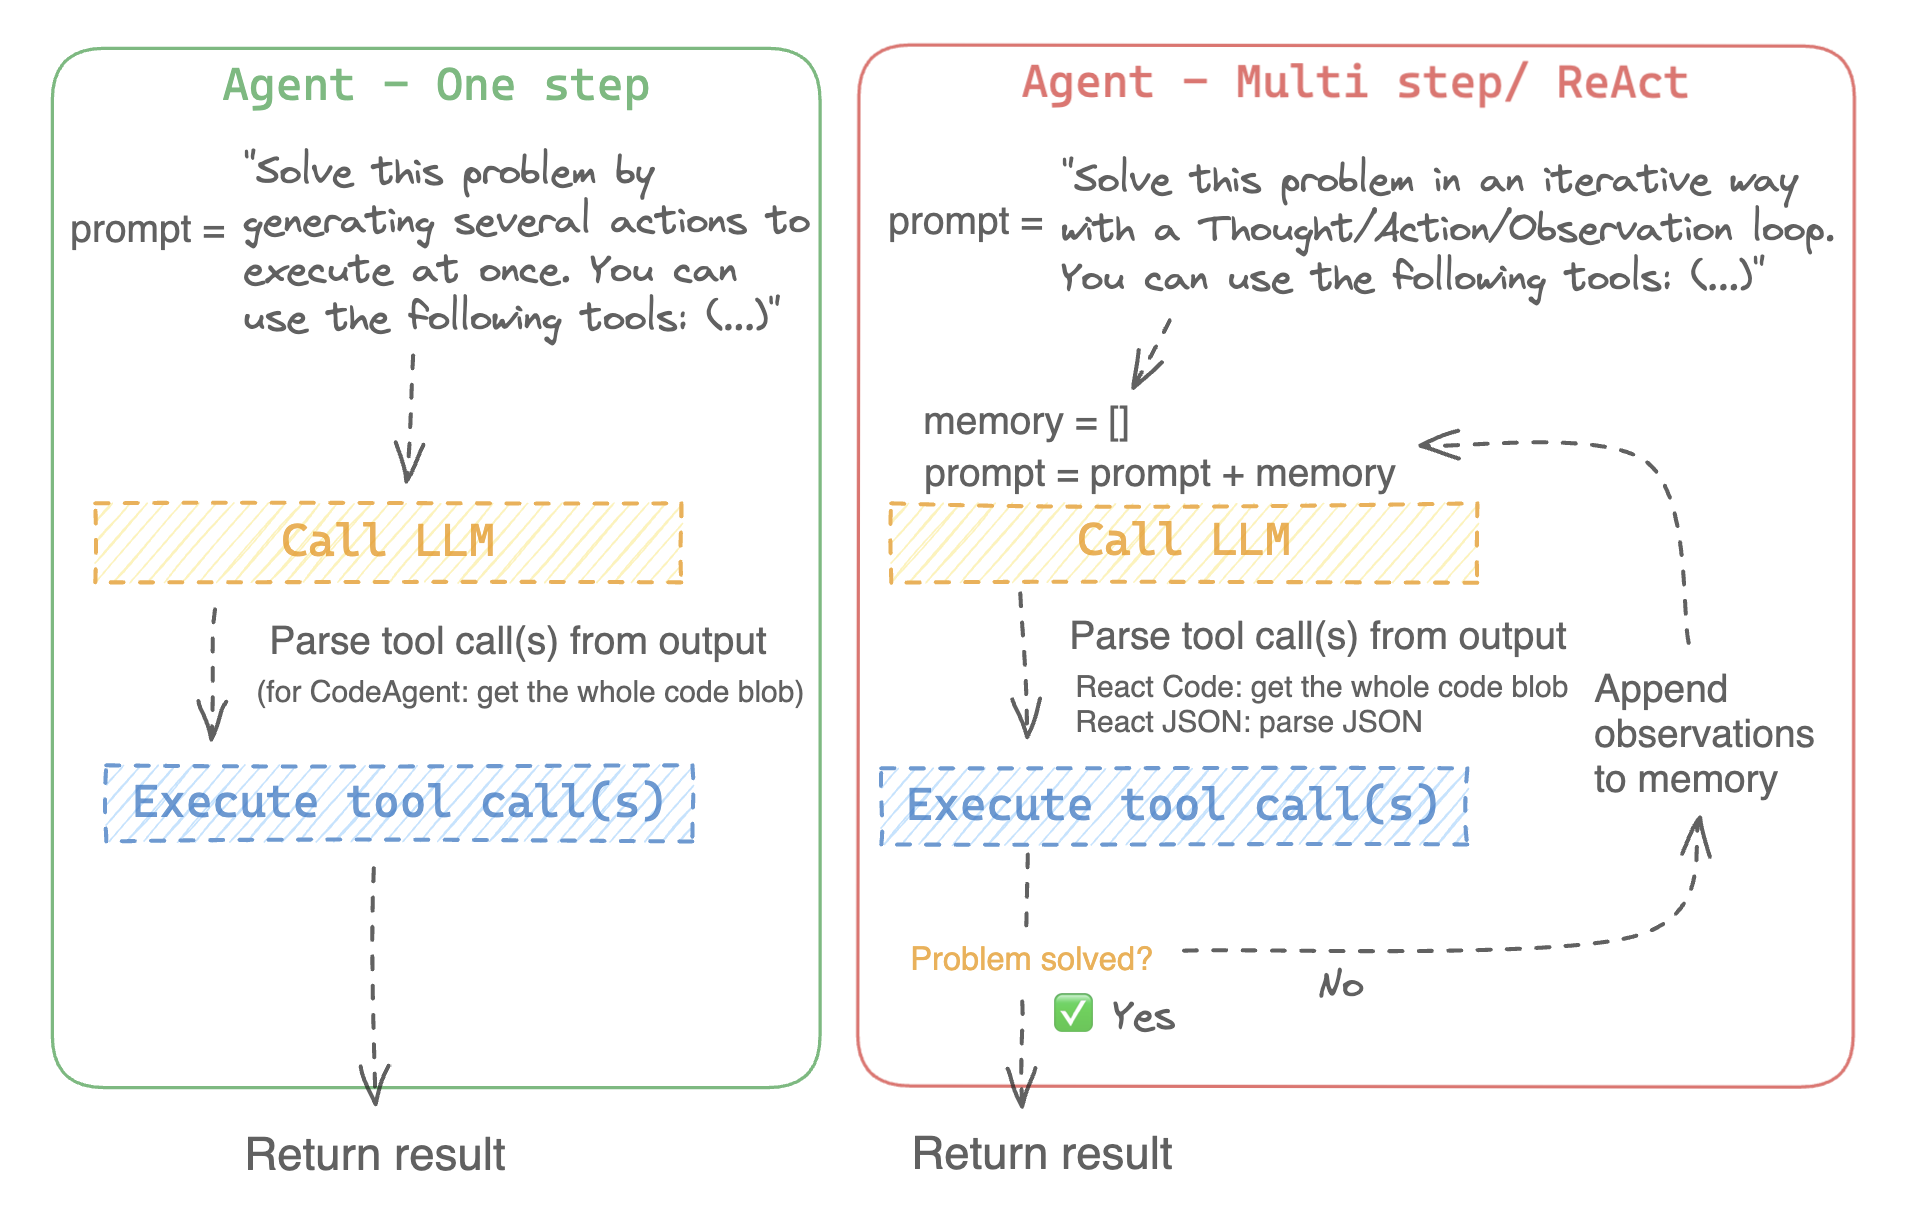

Installing the required dependencies

In [1]:
!pip install "git+https://github.com/huggingface/transformers.git#egg=transformers[agents]"


DEPRECATION: git+https://github.com/huggingface/transformers.git#egg=transformers[agents] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-install-f3vcv4l9/transformers_626ae613714b4b1d8e74c185d14f10dc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-install-f3vcv4l9/transformers_626ae613714b4b1d8e74c185d14f10dc
  Resolved https://github.com/huggingface/transformers.git to commit bdb9106f247fca48a71eb384be25dbbd29b065a8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [3]:
!pip install sentence-transformers==2.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 4.1 MB/s eta 0:00:00


In [4]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 51.0 MB/s eta 0:00:00


In [5]:
from huggingface_hub import notebook_login

notebook_login()


I will be using documents from huggingface itself and store them in a Faiss Vector Store and use that Vector Store as a Database for the RAG Agent to query from. This Dataset consists of 2800 rows of textual data along with the source column.
This data source can be easily replaced by any other custom data source and have this pipeline perform the same actions.

In [6]:
import datasets
knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

I will also be using a few Libraries from Langchain to split and chunk the documents and Embeddings from HuggingFace to convert the chunks into Vectors.

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
model = AutoModel.from_pretrained("thenlper/gte-small")

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

In [8]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(
        page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]}
    ) for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(source_docs)[:1000]


model_kwargs = {'trust_remote_code': True}
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small",model_kwargs=model_kwargs)                # Update the Vector Store with chunks of the Documents

vectordb = FAISS.from_documents(
    documents=docs_processed,
    embedding=embedding_model
)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))     # Printing the various sources of the Documents
print(all_sources)


['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-models', 'optimum', 'datasets-server', 'transformers', 'gradio']


In the below cell, I will be defining a tool that the Agent will have access to. Depending on the context the agent will choose the correct tool to use based on the Description of the tool.

In [10]:
import json
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore

class RetrieverTool(Tool):
    name = "retriever"
    description = "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "text",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {
            "type": "text",
            "description": ""
        },
    }
    output_type = "text"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"]["description"] = (
            f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched."
          )

    def forward(self, query: str, source: str = None) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        if source:
            if isinstance(source, str) and "[" not in str(source): # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(query, filter=({"source": source} if source else None), k=3)

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            [doc.page_content for doc in docs]
        )


In the following cell, I will be downloading the LLM and Initialise the agent. During initialisation the agent can need:


*   tools: a list of tools that the agent will be able to call.
*   llm_engine: the LLM that powers the agent.



In [11]:
from transformers.agents import HfEngine, ReactJsonAgent

llm_engine = HfEngine("meta-llama/Meta-Llama-3-8B-Instruct")

agent = ReactJsonAgent(
    tools=[RetrieverTool(vectordb, all_sources)],
    llm_engine=llm_engine,
    verbose=False
)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)


======== New task ========
Please show me a LORA finetuning script
Calling tool: 'retriever' with arguments: {'query': {'type': 'text', 'description': 'LORA finetuning script'}, 'source': ['blog', 'hub-docs']}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-models', 'optimum

Final output:
I was not able to find a LORA finetuning script. The retrieved documents were not relevant to the task. If you would like, I can try again or provide a new approach to solve the task.


In [12]:
agent_output = agent.run("What is an Iterable Dataset")

print("Final output:")
print(agent_output)


======== New task ========
What is an Iterable Dataset
Calling tool: 'retriever' with arguments: {'query': {'type': 'text', 'description': 'What is an Iterable Dataset'}, 'source': ['datasets', 'transformers', 'hub-docs']}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-mode

Final output:
An IterableDataset is a type of dataset object that provides a lazy behavior and speed advantages, ideal for big datasets. It can be used by switching a map-style Dataset to an IterableDataset using the `to_iterable_dataset()` method.


In [13]:
agent_output = agent.run("What is Wide Resnet")

print("Final output:")
print(agent_output)


======== New task ========
What is Wide Resnet
Calling tool: 'retriever' with arguments: {'query': {'type': 'text', 'description': 'What is Wide Resnet'}, 'source': 'hub-docs'}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-models', 'optimum', 'datasets-server', 'transforme

Final output:
Wide Resnet is a type of Residual Network architecture that uses a wider и deeper network to improve the accuracy of image classification and object detection tasks.


In [14]:
agent_output = agent.run("Please show mehow to track NL tasks with Transformers")

print("Final output:")
print(agent_output)


======== New task ========
Please show mehow to track NL tasks with Transformers
Calling tool: 'retriever' with arguments: {'query': {'type': 'text', 'description': 'How to track NL tasks with Transformers'}, 'source': ['hub-docs']}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-

Final output:
It seems that tracking NL tasks with Transformers involves using models such as the Neighborhood Attention Transformer (NAT) and fine-tuning them for specific tasks using the `Trainer` API. Additionally, there are examples of scripts for fine-tuning models for various tasks, and documentation on how to use the `Tokenizer` class for preprocessing data. Furthermore, there is a task summary that outlines the tasks supported by Transformers.


In [15]:
agent_output = agent.run("How do I setup a Basic Gradio app?")

print("Final output:")
print(agent_output)


======== New task ========
How do I setup a Basic Gradio app?
Calling tool: 'retriever' with arguments: {'query': {'description': 'Setup a basic Gradio app'}, 'source': 'hub-docs'}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-models', 'optimum', 'datasets-server', 'transf

Final output:
To set up a basic Gradio app, you can install the Gradio library using pip:!pip install -q gradio. Then, you can create a blocks-based demo using Gradio's API, as shown in the retrieved documents.


In [16]:
agent_output = agent.run("Tell me how to Fine Tune a Masked Language Model")

print("Final output:")
print(agent_output)


======== New task ========
Tell me how to Fine Tune a Masked Language Model
Calling tool: 'retriever' with arguments: {'query': {'type': 'text', 'description': 'fine-tune masked language model'}, 'source': ['transformers']}
Error in tool call execution: Your search query must be a string
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'query': {'type': 'text', 'description': 'The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.'}, 'source': {'type': 'text', 'description': "The source of the documents to search, as a str representation of a list. Possible values in the list are: ['blog', 'diffusers', 'course', 'hub-docs', 'evaluate', 'datasets', 'deep-rl-class', 'peft', 'hf-endpoints-documentation', 'pytorch-image-mod

Final output:
Please refer to the documents retrieved from the Hugging Face Transformers library for details on how to fine-tune a masked language model.


The outputs are riddled with a bunch of errors and this is expected because the new ReACT agent package from huggingface is still very new and still in development, but if you look past the errors, the agent is able to answer all the queries correctly at the end of the output.